# **Uniform Coloring**
Sviluppato da Stefania Fiorelli e Miriam Calandri
### Indice
- [Dominio](#dominio)
- [Modello](#creazione-del-modello)
- [Acquisizione immagini](#acquisizione-immagini)
- [Problema](#modellazione-del-problema)
- [Animazione](#animazione-della-soluzione-trovata)


## **Dominio**
UniformColoring è composto da una griglia rettangolare e una testina. La griglia è divisa in celle, di cui una cella di partenza T, posizione iniziale della testina, e le rimanenti colorate Green G, Yellow Y, Blue B. La testina ha l'obiettivo di colorare tutte le celle, eccetto T, dello stesso colore e ritornare in T.

La testina può svolgere due azioni: spostarsi nelle quattro direzioni cardinali e colorare la cella in cui si trova.  
Gli spostamenti hanno un costo uniforme pari a 1.  
L'azione di colorare un cella ha costo dipendente dal colore: $cost(G) = 3$, $cost(Y) = 2$, $cost(B) = 1$.

Il costo del percorso è calcolato sommando i costi degli spostamenti ai costi della colorazione delle celle.  
*es.*  
**Stato Iniziale**
```
G T G B
G Y G B
```

**Possibile Stato Goal**
```
G T G G
G G G G
```
**Possibile Soluzione**: $actions = move(S), color(G), move(E), move(E), color(G), move(N), color(G), move(W), move(W)$  
**Costo**: $path\_cost = move(S).cost + color(G).cost + move(E).cost + ... + move(W).cost + move(W).cost = 15$  
**Lunghezza**: $sum(actions) = 9$

L'agente deve rispettare i seguenti vincoli:
- **v1** = "l'agente può muoversi solo all'interno della griglia"
- **v2** = "l'agente può compiere un solo passo alla volta"
- **v3** = "l'agente può muoversi solo lungo le direzioni North/South/East/West"
- **v4** = "l'agente non può muoversi in diagonale"
- **v5** = "l'agente può colorare solo la cella in cui si trova"
- **v6** = "l'agente non può colorare T"
- **v7** = "l'agente non può colorare una cella del colore di cui è già colorata"
- **v8** =  "l'agente non può colorare la griglia se è già colorata di un solo colore"

La griglia deve rispettare i seguenti vincoli:
- **v8** = "la griglia deve avere dimensioni minime 2x2"
- **v9** = "la griglia deve avere una sola cella T"
- **v10** = "la griglia può avere solo celle di colore G, Y, B"



### **Caricamento librerie**

In [1]:
from aima import Problem, Node, memoize
from aima import uniform_cost_search, iterative_deepening_search, breadth_first_graph_search, depth_first_graph_search, astar_search, best_first_graph_search
from collections.abc import Callable
from dataclasses import dataclass
from emnist import extract_training_samples, extract_test_samples
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, log_loss, precision_score, recall_score, accuracy_score
from pygame.locals import *
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import pygame
import time
import math
import cv2

pygame 2.6.1 (SDL 2.28.4, Python 3.10.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


### **Funzioni di utility**

In [2]:
# Colori da usare nella print()
PRINT_BLUE = "\033[34;1m"
PRINT_RED = "\033[31;1m"
PRINT_GREEN = "\033[32;1m"
PRINT_YELLOW  = '\033[33m'
PRINT_RESET = "\033[0m"

@dataclass
class Result:
    result: Node
    nodes_generated: int
    paths_explored: int
    nodes_left_in_frontier: int

# Funzione per eseguire gli algoritmi e stampare alcune informazioni come
# risultato, costi della soluzione e tempo di esecuzione.
def execute(name: str, algorithm: Callable, problem: Problem, *args, **kwargs):
    print(f"{PRINT_RED}{name}{PRINT_RESET}\n")
    start = time.time()
    sol = algorithm(problem, *args, **kwargs)
    end = time.time()

    if isinstance(sol, Result):
        print(f"{PRINT_GREEN}Total nodes generated:{PRINT_RESET} {sol.nodes_generated}")
        print(f"{PRINT_GREEN}Paths explored:{PRINT_RESET} {sol.paths_explored}")
        print(f"{PRINT_GREEN}Nodes left in frontier:{PRINT_RESET} {sol.nodes_left_in_frontier}")
        sol = sol.result
    print(f"{PRINT_GREEN}Result:{PRINT_RESET} {sol.solution() if sol is not None else '---'}")
    print(f"{PRINT_GREEN}Initial State:{PRINT_RESET} {problem.initial}")
    if isinstance(sol, Node):
        print(f"{PRINT_GREEN}Path Cost:{PRINT_RESET} {sol.path_cost}")
        print(f"{PRINT_GREEN}Path Length:{PRINT_RESET} {sol.depth}")
        print(f"{PRINT_GREEN}End State:{PRINT_RESET} {sol.state}")
    print(f"{PRINT_GREEN}Time:{PRINT_RESET} {end - start} s")
    return sol.solution(), problem.initial


def greedy(problem: Problem, h: Callable | None = None) -> Node:
  h = memoize(h or problem.h, 'h')
  return best_first_graph_search(problem, lambda node : h(node))

### **Riconoscimento griglia e resizing delle immagini**


In [3]:
# Costante per il blur:
# devono essere numeri dispari, più sono elevati, più è blurred
BLUR_LEVEL = (9, 9)
CROP_TOLERANCE = 10

def capture_letters(original_image):
    plt.imshow(original_image, 'Grays')
    plt.show()

    # Crea una copia dell'immagine originale
    img =  original_image.copy()

    # Converte in 1 solo canale (RGB -> GRAYSCALE)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 127 = valore del pixel threshold, THRESH_BINARY ritorna in bianco e nero a colori invertiti
    # la flag THRESH_OTSU sceglie automaticamente il threshold ottimale (invece di 127)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Trova il contour più esterno
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = contours[np.argmax([cv2.contourArea(contour) for contour in contours])]
    x, y, w, h = cv2.boundingRect(max_contour)

    # Ritaglia l'immagine al contorno più esterno
    thresh = thresh.copy()
    crop_thresh = thresh[y:y+h, x:x+w]
    img1 = img.copy()
    crop_norm = img1[y:y+h, x:x+w]

    rectangles = crop_norm.copy()

    # Blur per eliminare il rumore
    blur = cv2.GaussianBlur(crop_thresh, BLUR_LEVEL, 0)

    # Trova i countour dell'immagine ritagliata
    contours, hierarchy = cv2.findContours(blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    coordinates = []

    min_hier = 0
    for i, contour in enumerate(contours):
        [x, y, w, h] = cv2.boundingRect(contour)

    # Seleziona dall'immagine ritagliata i contour con parent hierarchy = 0 e che siano più grandi di 20x20 pixel
        if(hierarchy[0][i][3] == min_hier and h * w > 400):

                # Stampa il contour con gerarchia hierarchy = min_hier
                cv2.rectangle(rectangles, (x + CROP_TOLERANCE, y + CROP_TOLERANCE), (x + w - CROP_TOLERANCE, y + h - CROP_TOLERANCE), (0, 255, 0), 2)

                # Ritaglia l'area del rettangolo trovato
                roi = crop_norm[y+CROP_TOLERANCE:y+h-CROP_TOLERANCE, x+CROP_TOLERANCE:x+w-CROP_TOLERANCE]
                coordinates.append((x, y, roi))
                
    # Visualizzo i contour trovati
    plt.imshow(rectangles, 'Grays')
    plt.show()

    # Trovo il numero di righe e di colonne della matrice
    # paragonando le immagino con x,y simili
    rows = 0
    cols = 0
    element = coordinates[0]
    for c in coordinates:
        if abs(element[0] - c[0]) < 80:
            rows += 1

        if abs(element[1] - c[1]) < 80:
            cols += 1

    # Ordino per le y
    coordinates.sort(key = lambda y : y[1])
    k = 0
    row = []
    matrix = []
    for i in range(0, len(coordinates)):
        row.append(coordinates[i])
        k += 1
        if k == cols:
            row.sort(key = lambda x : x[0])
            matrix.append(row)
            k = 0
            row = []
    
    print(f"Trovata matrice con {rows} righe e {cols} colonne.")
    return matrix, rows, cols

# Processa l'immagine per adeguarla al modello
def process_image(image, length = 28) -> np.ndarray:
    height, width, _ = image.shape

    # Se è già un quadrato, basta diminuire la risoluzione
    if width == height:
        resized_image = cv2.resize(image, (length, length))

    # Se è in modalità ritratto (pià alta che larga),
    # ritaglia la larghezza mantenendo l'aspect ratio
    elif width < height:
        resized_image = cv2.resize(image, (length, int(height * (length / width))))

        # Calcola quanto tagliare in altezza
        res_height, res_width, _ = resized_image.shape
        required_loss = res_height - length

        # Ritaglia sopra e sotto per mantenere il centro
        crop_start = required_loss // 2
        crop_end = res_height - (required_loss // 2)
        resized_image = resized_image[crop_start:crop_end, 0:res_width]

    # Se invece è in modalità panorama (larghezza maggiore dell'altezza),
    # ritaglia l'altezza mantenendo l'aspect ratio
    else:
        resized_image = cv2.resize(image, (int(width * (length / height)), length))

        # Calcola quanto tagliare in larghezza
        res_height, res_width, _ = resized_image.shape
        required_loss = res_width - length

        # Ritaglia destra e sinistra per mantenere il centro
        crop_start = required_loss // 2
        crop_end = res_width - (required_loss // 2)
        resized_image = resized_image[0:res_height, crop_start:crop_end]

    # Rende l'immagine in bianco e nero ed applica un threshold
    resized_image = cv2.resize(image, (length, length))
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    _ , img = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    plt.imshow(img, cmap='Grays_r')
    plt.show()

    # Rimodella della matrice 28x28 in un vettore 1D di 784 elementi
    sample = img.reshape(1, -1)
    return sample
    

### **Caricamento Dataset**
Carichiamo il dataset *EMNIST balanced* che contiene: lettere maiuscole, alcune lettere minuscole e numeri. Per ogni lettera sono presenti 2800 immagini, di cui $\dfrac{1}{7}$ è riservato al testing e il restante al training. Separiamo le lettere che ci interessano per addestrare il modello, ovvero B, G, T, Y e le reindicizziamo.

(9600, 28, 28) (1600, 28, 28)


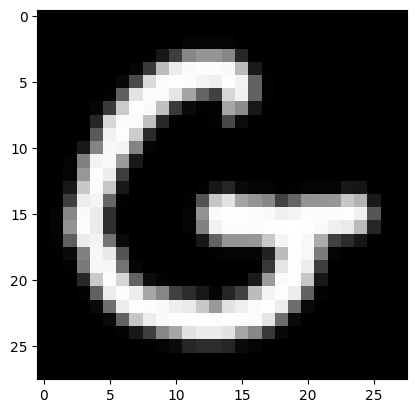

In [4]:
# Etichette del dataset originale
letters_raw = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
               'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

# Nuovi indici delle etichette B, G, T, Y
to_keep = [11, 16, 29, 34]
letters = ['B', 'G', 'T', 'Y']

# Caricamento del dataset
x_train_raw, y_train_raw = extract_training_samples('balanced')
x_test_raw, y_test_raw = extract_test_samples('balanced')

# Crea degli array vuoti per il dataset filtrato
x_train = np.zeros((9600, 28, 28), dtype=x_train_raw.dtype)
y_train = np.zeros((9600,), dtype=y_train_raw.dtype)

x_test = np.zeros((1600, 28, 28), dtype=x_test_raw.dtype)
y_test = np.zeros((1600,), dtype=y_test_raw.dtype)

# Estrae dal dataset tutte le immagini contenti B, G, T, Y
# e gli assegna come etichetta il nuovo indice corrispondente
i = 0
for n in range(0, len(y_train_raw)):
    if y_train_raw[n] in to_keep: 
        x_train[i] = x_train_raw[n]
        y_train[i] = to_keep.index(y_train_raw[n])
        i += 1

i = 0
for n in range(0, len(y_test_raw)):
    if y_test_raw[n] in to_keep:
        x_test[i] = x_test_raw[n]
        y_test[i] = to_keep.index(y_test_raw[n])
        i += 1

print(x_train.shape, x_test.shape)
plt.imshow(x_train[randint(0, 9600)], cmap = "Grays_r")

### **Elaborazione del dataset per il modello**

In [5]:
print("Old training data shape:", x_train.shape)
print("Old test data shape:", x_test.shape)

# Rimodellazione della matrice 28x28 in un vettore 1D di 784 elementi
feature_vector_length = math.prod(x_train.shape[1:])

x_train_reshaped = x_train.reshape(x_train.shape[0], feature_vector_length)
x_test_reshaped = x_test.reshape(x_test.shape[0], feature_vector_length)

print("New training data shape:", x_train_reshaped.shape)
print("New test data shape:", x_test_reshaped.shape)

# Normalizzazione dei valori
minmax = MinMaxScaler()
x_train_norm = minmax.fit_transform(x_train_reshaped)
x_test_norm = minmax.fit_transform(x_test_reshaped)

print("Max pixel values:", np.max(x_train_norm))
print("Min pixel values:", np.min(x_train_norm))

Old training data shape: (9600, 28, 28)
Old test data shape: (1600, 28, 28)
New training data shape: (9600, 784)
New test data shape: (1600, 784)
Max pixel values: 1.0
Min pixel values: 0.0


## **Creazione del modello**
Utilizziamo un modello ANN, MultiLayerPerceptron per la classificazione delle lettere. Il modello scelto ha due hidden layers, composti da 8 neuroni e 5 neuroni. Dopo vari test, questo è risultato il modello con valori di loss, accuracy, precision e recall migliori. È stato modificato il valore di alpha ad 1, in quanto incoraggia i weights del modello ad assumere valori minori, riducendo l'overfitting.

Iteration 1, loss = 1.13396120
Iteration 1: train_loss=0.7856240101358263, test_loss=0.80369512374538

Iteration 1, loss = 0.69072496
Iteration 2: train_loss=0.49417410345832397, test_loss=0.5252745606006262

Iteration 1, loss = 0.47473927
Iteration 3: train_loss=0.335221839768235, test_loss=0.3755506639565451

Iteration 1, loss = 0.36480522
Iteration 4: train_loss=0.2530968379368013, test_loss=0.29869754086858963

Iteration 1, loss = 0.30640098
Iteration 5: train_loss=0.206565493673051, test_loss=0.25543283368070374

Iteration 1, loss = 0.27154283
Iteration 6: train_loss=0.17737158723035784, test_loss=0.22804698583965824

Iteration 1, loss = 0.24870004
Iteration 7: train_loss=0.15803412907682438, test_loss=0.20955630647756388

Iteration 1, loss = 0.23282846
Iteration 8: train_loss=0.14418724315644346, test_loss=0.19601010038131883

Iteration 1, loss = 0.22093147
Iteration 9: train_loss=0.13398614343522686, test_loss=0.18625058308102369

Iteration 1, loss = 0.21171687
Iteration 10: tra

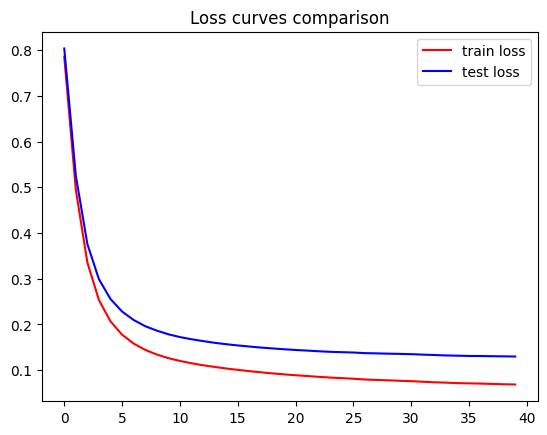

In [6]:
mlp = MLPClassifier(
    solver='adam',
    alpha=1,
    activation='relu',
    hidden_layer_sizes=(8,5),
    random_state=1,
    verbose=True
)

# Training del MLP e ritorna test e training loss
def fit_and_draw_loss(mlp, x_train, y_train, x_test, y_test, max_iter, verbose=0):
    train_losses = []
    test_losses = []
    for i in range(1, max_iter + 1):
        mlp.partial_fit(x_train, y_train, classes=np.unique(y_train))

        train_pred = mlp.predict_proba(x_train)
        train_loss = log_loss(y_train, train_pred)
        train_losses.append(train_loss)
        
        test_pred = mlp.predict_proba(x_test)
        test_loss = log_loss(y_test, test_pred)
        test_losses.append(test_loss)
        if verbose > 1: print(f"Iteration {i}: {train_loss=}, {test_loss=}\n")
    return train_losses, test_losses

# Disegna la funzione di loss di test e training
def draw_train_and_test_loss(train_losses, test_losses):
    plt.plot(train_losses, color="red", label="train loss")
    plt.plot(test_losses, color="blue", label="test loss")
    plt.title("Loss curves comparison")
    plt.legend()
    plt.show()

train_loss, test_loss = fit_and_draw_loss(mlp, x_train_norm, y_train, x_test_norm, y_test, 40, verbose=2)
draw_train_and_test_loss(train_loss, test_loss)

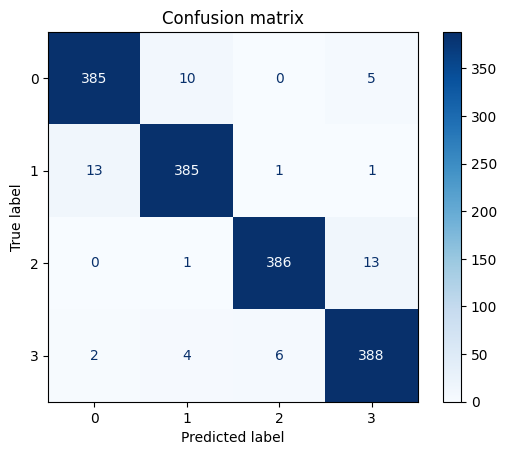

Accuracy:  0.965
Precision:  0.965126312120587
Recall:  0.965


In [7]:
y_pred = mlp.predict(x_test_norm)

def plot_confusion_matrix(cm, labels):
    display = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=labels
    )
    display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix, range(len(set(y_test))))
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

## **Acquisizione immagini**

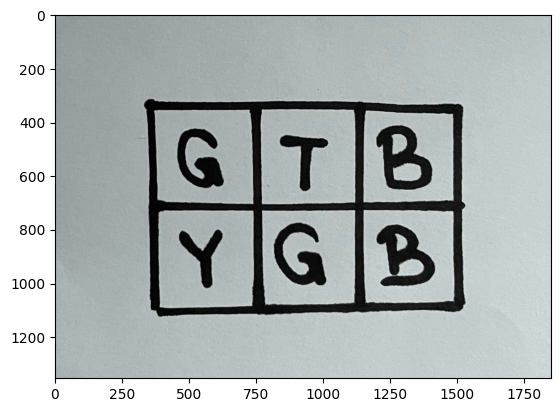

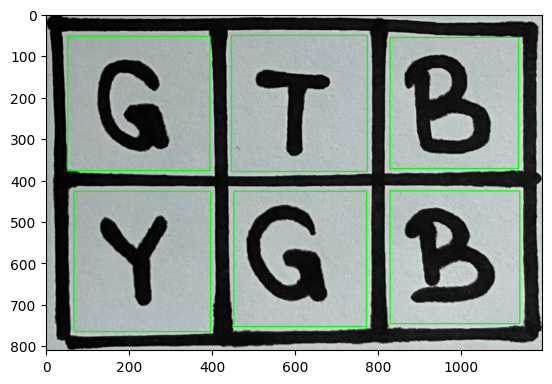

Trovata matrice con 2 righe e 3 colonne.


In [8]:
path = "input/test2.png"
image = cv2.imread(path)

matrix, rows, cols = capture_letters(image)
image_list = []
for i in range(0, rows):
    for j in range(0, cols):
        image_list.append(matrix[i][j])


### **Riconoscimento delle lettere**

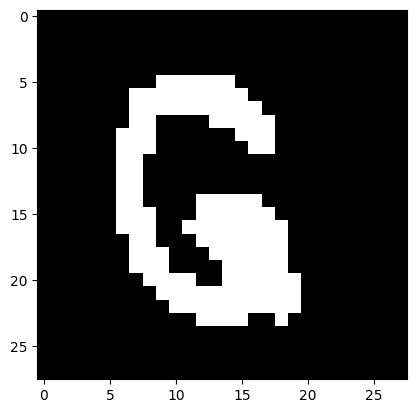

Predizione:  G


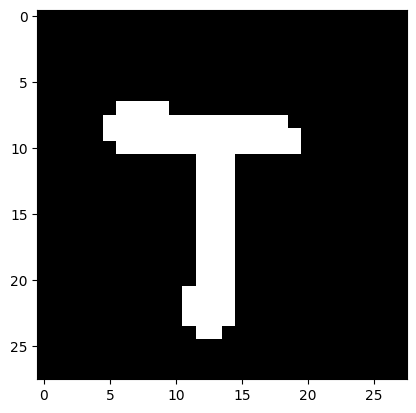

Predizione:  T


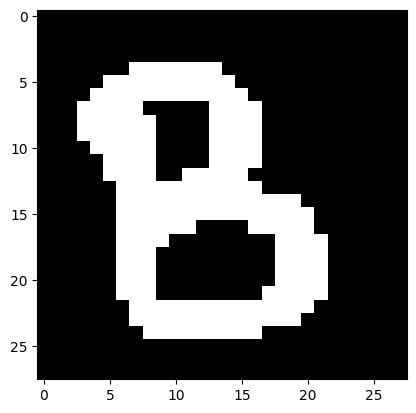

Predizione:  B


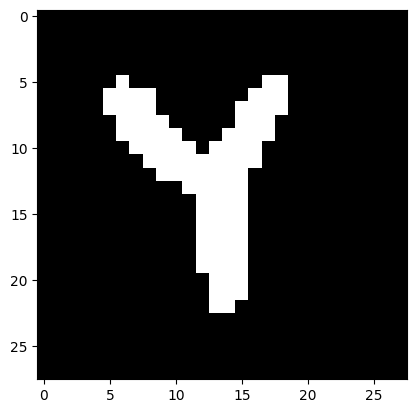

Predizione:  Y


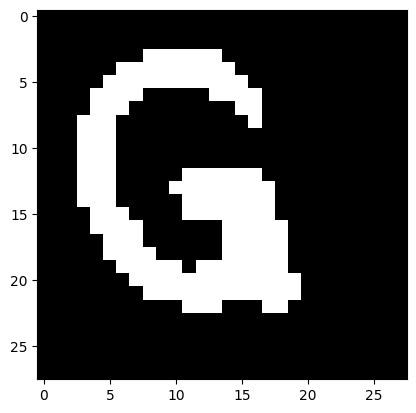

Predizione:  G


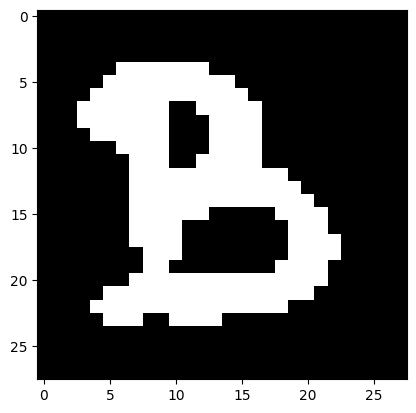

Predizione:  B


In [12]:
predictions = []

for i,image in enumerate(image_list):
    sample = process_image(image[2])
    pred = mlp.predict(sample)
    predictions.append(letters[pred[0]])
    print(f"Predizione: ", predictions[i])


## **Modellazione del problema**
La funzione euristica scelta è calcolata in base al costo di colorazione delle celle. Per ogni colore, calcola quanto costerebbe colorare tutte le celle che non sono colorate dello stesso, senza tenere conto degli spostamenti, e ritorna il valore minore.

color_green = numero di celle non verdi * costo di colorare di verde  
color_yellow = numero di celle non gialle * costo di colorare di giallo   
color_blue = numero di celle non blu * costo di colorare di blu  

$h(state) =  min(color\_green, color\_yellow, color\_blue)$

L'euristica è ammissibile, in quanto non tiene conto dei costi di spostamento della testina, perciò sottistima sempre il costo reale della soluzione ottima.
È inoltre consistente perchè non tenendo conto dei costi di spostamento, $ h(n) ≤ h(n') + c(n, a, n')$, per ogni azione possibile.

**L’euristica definita mantiene le stesse proprietà nel caso in cui le azioni di spostamento costassero 0 o le colorazioni avessero tutte lo stesso costo?**  
Sì, l'euristica mantiene le stesse proprietà di consistenza e quindi ammissibilità, perchè il costo che calcola è equivalente al costo del cammino ottimale, che sarà sempre basato sul numero maggiore di celle dello stesso colore.

In [13]:
class ColorState:

  def __init__(self, cursor_pos: int, environment: tuple, rows: int, cols: int) -> None:
    self.cursor_pos = cursor_pos
    self.environment = environment
    self.rows = rows
    self.cols = cols

  def is_env_valid(self) -> int:
    if self.rows > 1 and self.cols > 1:
      if self.rows * self.cols == len(self.environment) and self.environment.count('T') == 1:
        return True
    else:
      return False

  def __str__(self) -> str:
    return str(f"ColorState(pos={self.cursor_pos}, environment={self.environment}), rows={self.rows}, cols={self.cols}")
  
  def __hash__(self: 'ColorState'):
    return hash(f"{self.cursor_pos}{self.environment}")

  def __lt__(self, state: 'ColorState'): 
    return False

  def __eq__(self, state: 'ColorState'):
    return self.cursor_pos == state.cursor_pos and self.environment == state.environment

In [10]:
class UniformColoring(Problem):
    def __init__(self, initial: ColorState):
        self.initial = initial
        self.delta = {'MOVE-NORTH': -initial.cols, 'MOVE-SOUTH': initial.cols, 'MOVE-WEST': -1, 'MOVE-EAST': 1}
        self.action_cost = {'MOVE-NORTH': 1, 'MOVE-SOUTH': 1, 'MOVE-WEST': 1, 'MOVE-EAST': 1, 'COLOR-BLUE': 1, 'COLOR-YELLOW': 2, 'COLOR-GREEN': 3}
        
        if not initial.is_env_valid():
            raise ValueError(f"{PRINT_RED}Environment not valid.")


    def actions(self, state: ColorState) -> list[str]:        
        possible_actions = []
        
        is_all_green = state.environment.count('G') == len(state.environment) - 1
        is_all_yellow = state.environment.count('Y') == len(state.environment) - 1
        is_all_blue = state.environment.count('B') == len(state.environment) - 1
        
        if state.environment[state.cursor_pos] != 'T' and not (is_all_green or is_all_yellow or is_all_blue):
            if state.environment[state.cursor_pos] == 'Y':
                possible_actions.extend(['COLOR-GREEN', 'COLOR-BLUE'])
            
            if state.environment[state.cursor_pos] == 'G':
                possible_actions.extend(['COLOR-YELLOW', 'COLOR-BLUE'])

            if state.environment[state.cursor_pos] == 'B':
                possible_actions.extend(['COLOR-YELLOW', 'COLOR-GREEN'])
 
        # non sono nella prima colonna, posso andare a sinistra
        if state.cursor_pos % state.cols > 0:
            possible_actions.append('MOVE-WEST')

        # non sono nella prima riga, posso andare in alto
        if state.cursor_pos >= state.cols:
            possible_actions.append('MOVE-NORTH')          

        # non sono nell'ultima colonna, posso andare a destra
        if state.cursor_pos % state.cols != state.cols - 1:
            possible_actions.append('MOVE-EAST')           
    
        #  non sono nell'ultima riga, posso andare in basso
        if state.cursor_pos < len(state.environment) - state.cols:
            possible_actions.append('MOVE-SOUTH')
        
        return possible_actions
    
    def result(self, state: ColorState, action : str):
        if action == 'COLOR-YELLOW':
            new_environment = list(state.environment)
            new_environment[state.cursor_pos] = 'Y'
            return ColorState(state.cursor_pos, tuple(new_environment), state.rows, state.cols)
        
        if action == 'COLOR-GREEN':
            new_environment = list(state.environment)
            new_environment[state.cursor_pos] = 'G'
            return ColorState(state.cursor_pos, tuple(new_environment), state.rows, state.cols)
        
        if action == 'COLOR-BLUE':
            new_environment = list(state.environment)
            new_environment[state.cursor_pos] = 'B'
            return ColorState(state.cursor_pos, tuple(new_environment), state.rows, state.cols)

        new_position = state.cursor_pos + self.delta[action]
        return ColorState(new_position, state.environment, state.rows, state.cols)
    
    def goal_test(self, state: ColorState) -> bool:
        """ Given a state, return True if state is a goal state or False, otherwise """
        if self.initial.cursor_pos == state.cursor_pos:
            if state.environment.count('G') == len(state.environment) - 1:
                print(f"{PRINT_GREEN}Tutto colorato di green")
                return True
            elif state.environment.count('Y') == len(state.environment) - 1:
                print(f"{PRINT_YELLOW}Tutto colorato di yellow")
                return True
            elif state.environment.count('B') == len(state.environment) - 1:
                print(f"{PRINT_BLUE}Tutto colorato di blue")
                return True
        return False
    
    def path_cost(self, c, state1, action, state2):
        return c + self.action_cost[action]
    
    def h(self, node):
        state = node.state
        env_len = len(state.environment) - 1
        not_green = env_len - state.environment.count('G') 
        not_yellow = env_len - state.environment.count('Y')     
        not_blue = env_len - state.environment.count('B')

        greens_cost = not_green * self.action_cost['COLOR-GREEN']
        yellows_cost = not_yellow * self.action_cost['COLOR-YELLOW']
        blues_cost = not_blue * self.action_cost['COLOR-BLUE']
        
        return min(greens_cost, yellows_cost, blues_cost)


### **Risoluzione del problema**

In [14]:
initial_state = tuple(predictions)
state =  ColorState(initial_state.index('T'), initial_state, rows, cols)
coloring = UniformColoring(state)

#### **Ricerche informate**

In [15]:
# A Star
result1 = execute('A Star', astar_search, coloring)

# Greedy
result2 = execute('Greedy', greedy, coloring)

A Star

Tutto colorato di blue
Result: ['MOVE-WEST', 'COLOR-BLUE', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-NORTH']
Initial State: ColorState(pos=1, environment=('G', 'T', 'B', 'Y', 'G', 'B')), rows=2, cols=3
Path Cost: 7
Path Length: 7
End State: ColorState(pos=1, environment=('B', 'T', 'B', 'B', 'B', 'B')), rows=2, cols=3
Time: 0.008898258209228516 s
Greedy

Tutto colorato di blue
Result: ['MOVE-WEST', 'COLOR-BLUE', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-NORTH']
Initial State: ColorState(pos=1, environment=('G', 'T', 'B', 'Y', 'G', 'B')), rows=2, cols=3
Path Cost: 7
Path Length: 7
End State: ColorState(pos=1, environment=('B', 'T', 'B', 'B', 'B', 'B')), rows=2, cols=3
Time: 0.0021233558654785156 s


#### **Ricerche non informate**

In [16]:
# IDS
result3 = execute('IDS', iterative_deepening_search, coloring)

# DFS
result4 = execute('DFS', depth_first_graph_search, coloring)

IDS

Tutto colorato di blue
Result: ['MOVE-WEST', 'COLOR-BLUE', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-NORTH']
Initial State: ColorState(pos=1, environment=('G', 'T', 'B', 'Y', 'G', 'B')), rows=2, cols=3
Path Cost: 7
Path Length: 7
End State: ColorState(pos=1, environment=('B', 'T', 'B', 'B', 'B', 'B')), rows=2, cols=3
Time: 0.07352209091186523 s
DFS

Tutto colorato di blue
Result: ['MOVE-SOUTH', 'MOVE-EAST', 'COLOR-GREEN', 'MOVE-NORTH', 'MOVE-WEST', 'MOVE-WEST', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-EAST', 'MOVE-EAST', 'MOVE-NORTH', 'COLOR-GREEN', 'MOVE-SOUTH', 'MOVE-WEST', 'MOVE-WEST', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-EAST', 'MOVE-EAST', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-WEST', 'MOVE-WEST', 'MOVE-NORTH', 'COLOR-YELLOW', 'MOVE-SOUTH', 'MOVE-EAST', 'MOVE-EAST', 'MOVE-NORTH', 'COLOR-GREEN', 'MOVE-SOUTH', 'MOVE-WEST', 'MOVE-WEST', 'COLOR-GREEN', 'MOVE-EAST', 'MOVE-EAST', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-WEST', 'COLOR-BLUE', 'M

## **Animazione della soluzione trovata**

In [17]:
result = result1

# Prende l'input iniziale dall'algoritmo di ricerca
initial_state = result[1].environment
rows = result[1].rows
cols = result[1].cols
moves = result[0].copy()

# Definizione di eventi custom per le mosse della testina
MOVE_NORTH = pygame.event.custom_type()
MOVE_SOUTH = pygame.event.custom_type()
MOVE_EAST = pygame.event.custom_type()
MOVE_WEST = pygame.event.custom_type()
COLOR_BLUE = pygame.event.custom_type()
COLOR_GREEN = pygame.event.custom_type()
COLOR_YELLOW = pygame.event.custom_type()

events = {'MOVE-EAST': MOVE_EAST, 'MOVE-WEST': MOVE_WEST, 'MOVE-NORTH': MOVE_NORTH, 'MOVE-SOUTH': MOVE_SOUTH, 
          'COLOR-BLUE': COLOR_BLUE, 'COLOR-YELLOW': COLOR_YELLOW, 'COLOR-GREEN': COLOR_GREEN}

# Setup della finestra
square_size = 150 
border_width = 3

window_width = cols * square_size + border_width
window_height = rows * square_size + border_width

# Colori delle sprite e delle celle
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
YELLOW = (249, 232, 0)
BLUE = (0, 41, 249)
GREEN = (0, 249, 33)

blank_sprite = pygame.image.load("sprites/blank.png")
green_sprite = pygame.image.load("sprites/green.png")
blue_sprite = pygame.image.load("sprites/blue.png")
yellow_sprite = pygame.image.load("sprites/yellow.png")

# Classe per la testina
class Cursor(pygame.sprite.Sprite):
    def __init__(self, image, pos, pixels):
        super().__init__()
        self.image = image.convert_alpha()
        self.rect = self.image.get_rect()
        self.pos = pos
        self.pixels = pixels
        self.delta = { MOVE_NORTH: -cols, MOVE_SOUTH: cols, MOVE_WEST: -1, MOVE_EAST: 1 }

    # Imposta la posizione iniziale della testina in base alla posizione di T nello stato iniziale
    def set_initial_position(self, pos):
        self.rect.x = pos%cols * square_size + border_width
        self.rect.y = pos//cols * square_size + border_width

    # Aggiorna la posizione nella tupla dello stato in base all'azione eseguita
    def update_pos(self, action):
        self.pos += self.delta[action]

    # Aggiorna la sprite in base all'azione
    def update_sprite(self, color):
        if color == COLOR_BLUE:
            self.image = blue_sprite
        
        elif color == COLOR_GREEN:
            self.image = green_sprite
        
        elif color == COLOR_YELLOW:
            self.image = yellow_sprite
        
        else: 
            self.image = blank_sprite
    
    # Sposta la testina nella griglia
    def move(self, direction):
        if direction == MOVE_EAST:
            self.rect.x += self.pixels

        elif direction == MOVE_WEST:
            self.rect.x -= self.pixels

        elif direction == MOVE_NORTH:
            self.rect.y -= self.pixels

        elif direction == MOVE_SOUTH:
            self.rect.y += self.pixels

# Funzione per disegnare la griglia, data in input la tupla dello stato
def draw_grid(state): 
    i = 0
    for y in range(border_width, window_height, square_size):
        for x in range(border_width, window_width, square_size):
            border = pygame.Rect(x, y, square_size, square_size)
            pygame.draw.rect(window, BLACK, border, border_width)

            rect = pygame.Rect(x, y, square_size-border_width, square_size-border_width)
            if state[i] == 'Y':
                pygame.draw.rect(window, YELLOW, rect, 0)
            if state[i] == 'G':
                pygame.draw.rect(window, GREEN, rect, 0)
            if state[i] == 'B':
                pygame.draw.rect(window, BLUE, rect, 0)               
            if state[i] == 'T':
                pygame.draw.rect(window, WHITE, rect, 0)
            i+=1

# Funzione per aggiornare lo stato dopo un'azione
def update_state(state, position, action):
    new_color = ''
    if action == COLOR_BLUE:
        new_color = 'B'
    elif action == COLOR_GREEN:
        new_color = 'G'
    elif action == COLOR_YELLOW:
        new_color = 'Y'

    new_state = list(state)
    new_state[position] = new_color
    return tuple(new_state)

# Inizializza la finestra e imposta i parametri iniziali
pygame.display.init()
window = pygame.display.set_mode((window_width, window_height))
pygame.display.set_caption("Uniform Coloring")
pygame.display.set_icon(blank_sprite)

clock = pygame.time.Clock()
is_running = True
sprites = pygame.sprite.Group()

cursor = Cursor(blank_sprite, initial_state.index('T'), square_size) 
sprites.add(cursor)

cursor.set_initial_position(initial_state.index('T'))
current_state = initial_state

# Ciclo di esecuzione
while is_running:
    # Refresh rate della finestra 
    clock.tick(1.5)

    draw_grid(current_state)
    sprites.draw(window)
    
    pygame.display.update()

    # Se non ci sono più mosse disponibili, 
    # attende 5 secondi e termina l'esecuzione
    if not moves:
        pygame.time.delay(5000)
        is_running = False
        pygame.display.quit()
        break
    
    # Invia l'evento corrispondente alla mossa eseguita
    pygame.event.post(pygame.event.Event(events[moves[0]]))
    pygame.display.set_caption(moves[0])
    moves.remove(moves[0])

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            is_running = False
            pygame.display.quit()
        
        if event.type in [MOVE_EAST, MOVE_WEST, MOVE_SOUTH, MOVE_NORTH]:
            cursor.move(event.type)
            cursor.update_pos(event.type)
            cursor.update_sprite(event.type)
      
        if event.type in [COLOR_BLUE, COLOR_YELLOW, COLOR_GREEN]:
            current_state = update_state(current_state, cursor.pos, event.type)
            cursor.update_sprite(event.type)
    

### **Analisi delle prestazioni di ricerca**


## **Matrice 2x2**
**Initial State:** `('T', 'Y', 'G', 'G')`

![2x2](./ricerca/2x2.png)

### A Star
||| 
| --- | --- | 
| **End State** | `('T', 'G', 'G', 'G')` |
| **Result** | `['MOVE-EAST', 'COLOR-GREEN', 'MOVE-WEST']`|
| **Path Cost** | `5` |
| **Path Length** | `3` |
| **Time** | `0.0003643035888671875s` |

### Greedy
||| 
| --- | --- | 
| **End State** | `('T', 'G', 'G', 'G')` | 
| **Result** | `['MOVE-EAST', 'COLOR-GREEN', 'MOVE-WEST']` | 
| **Path Cost** | `5` | 
| **Path Length** | `3` | 
| **Time** | `8.749961853027344e-05s` | 

### IDS
||| 
| --- | --- | 
| **End State** | `('T', 'G', 'G', 'G')` | 
| **Result** | `['MOVE-EAST', 'COLOR-GREEN', 'MOVE-WEST']` | 
| **Path Cost** | `5` | 
| **Path Length** | `3` | 
| **Time** | `0.00023508071899414062s` | 

### DFS
||| 
| --- | --- | 
| **End State** | `('T', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-SOUTH', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-WEST', 'COLOR-BLUE', 'MOVE-NORTH']` | 
| **Path Cost** | `9` | 
| **Path Length** | `9` | 
| **Time** | `0.00022101402282714844s` | 


## **Matrice 2x3**
**Initial State:** `('G', 'T', 'B', 'Y', 'G', 'B')`

![2x3](./ricerca/2x3.png)

### A Star
||| 
| --- | --- | 
| **End State** | `('B', 'T', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-WEST', 'COLOR-BLUE', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-NORTH']` | 
| **Path Cost** | `7` | 
| **Path Length** | `7` | 
| **Time** | `0.01684117317199707s` | 

### Greedy
||| 
| --- | --- | 
| **End State** | `('B', 'T', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-WEST', 'COLOR-BLUE', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-NORTH']` | 
| **Path Cost** | `7` | 
| **Path Length** | `7` | 
| **Time** | `0.0028526782989501953s` | 

### IDS
||| 
| --- | --- | 
| **End State** | `('B', 'T', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-WEST', 'COLOR-BLUE', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-NORTH']` | 
| **Path Cost** | `7` | 
| **Path Length** | `7` | 
| **Time** | `0.05534696578979492s` | 

### DFS
||| 
| --- | --- | 
| **End State** | `('B', 'T', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-SOUTH', 'MOVE-EAST', 'COLOR-GREEN', 'MOVE-NORTH', 'MOVE-WEST', 'MOVE-WEST', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-EAST', 'MOVE-EAST', 'MOVE-NORTH', 'COLOR-GREEN', 'MOVE-SOUTH', 'MOVE-WEST', 'MOVE-WEST', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-EAST', 'MOVE-EAST', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-WEST', 'MOVE-WEST', 'MOVE-NORTH', 'COLOR-YELLOW', 'MOVE-SOUTH', 'MOVE-EAST', 'MOVE-EAST', 'MOVE-NORTH', 'COLOR-GREEN', 'MOVE-SOUTH', 'MOVE-WEST', 'MOVE-WEST', 'COLOR-GREEN', 'MOVE-EAST', 'MOVE-EAST', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-WEST', 'COLOR-BLUE', 'MOVE-EAST', 'MOVE-NORTH', 'COLOR-GREEN', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-NORTH', 'MOVE-WEST', 'MOVE-WEST', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-EAST', 'MOVE-EAST', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-WEST', 'MOVE-WEST', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-EAST']` | 
| **Path Cost** | `74` | 
| **Path Length** | `63` | 
| **Time** | `0.008691072463989258s` | 


## **Matrice 3x3**
**Initial State:** `('G', 'Y', 'T', 'B', 'Y', 'G', 'Y', 'B', 'B')`

![3x3](./ricerca/3x3.png)

### A Star
||| 
| --- | --- | 
| **End State** | `('B', 'B', 'T', 'B', 'B', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-WEST', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-WEST', 'COLOR-BLUE', 'MOVE-NORTH', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-EAST']` | 
| **Path Cost** | `13` | 
| **Path Length** | `13` | 
| **Time** | `1.0945510864257812s` | 

### Greedy
||| 
| --- | --- | 
| **End State** | `('B', 'B', 'T', 'B', 'B', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-WEST', 'COLOR-BLUE', 'MOVE-WEST', 'COLOR-BLUE', 'MOVE-EAST', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-WEST', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-NORTH', 'MOVE-EAST', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-NORTH']` | 
| **Path Cost** | `15` | 
| **Path Length** | `15` | 
| **Time** | `0.0017175674438476562s` | 

### IDS
||| 
| --- | --- | 
| **End State** | `('B', 'B', 'T', 'B', 'B', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-WEST', 'COLOR-BLUE', 'MOVE-WEST', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-NORTH', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-NORTH']` | 
| **Path Cost** | `13` | 
| **Path Length** | `13` | 
| **Time** | `264.28123354911804s` | 

### DFS
||| 
| --- | --- | 
| **End State** | `('Y', 'Y', 'T', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y')` | 
| **Result** | `['MOVE-SOUTH', 'MOVE-SOUTH', 'MOVE-WEST', 'MOVE-WEST', 'MOVE-NORTH', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-SOUTH', 'MOVE-EAST', ..., 'MOVE-NORTH', 'MOVE-NORTH']` | 
| **Path Cost** | `25269` | 
| **Path Length** | `20468` | 
| **Time** | `581.328325510025s` | 
*Il risultato calcolato dalla DFS è stato in parte tagliato in quanto troppo lungo.*


## **Matrice 2x4**
**Initial State:** `('B', 'T', 'Y', 'Y', 'G', 'B', 'B', 'B')`

![2x4](./ricerca/2x4.png)

### A Star
|||
| --- | --- | 
| **End State** | `('B', 'T', 'B', 'B', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-WEST', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-NORTH', 'MOVE-EAST', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-WEST', 'MOVE-WEST']` | 
| **Path Cost** | `11` | 
| **Path Length** | `11` | 
| **Time** | `0.06952810287475586s` | 

### Greedy
||| 
| --- | --- | 
| **End State** | `('B', 'T', 'B', 'B', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-EAST', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-WEST', 'MOVE-WEST', 'MOVE-WEST', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-NORTH', 'MOVE-EAST']` | 
| **Path Cost** | `11` | 
| **Path Length** | `11` | 
| **Time** | `0.0008020401000976562s` | 

### IDS
|||
| --- | --- | 
| **End State** | `('B', 'T', 'B', 'B', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-WEST', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-NORTH', 'MOVE-EAST', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-WEST', 'MOVE-WEST']` | 
| **Path Cost** | `11` | 
| **Path Length** | `11` | 
| **Time** | `8.732128620147705s` | 

### DFS
||| 
| --- | --- | 
| **End State** | `('B', 'T', 'B', 'B', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-SOUTH', 'MOVE-EAST', 'MOVE-EAST', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-WEST', 'MOVE-WEST', 'MOVE-NORTH', 'MOVE-WEST', ..., 'COLOR-BLUE', 'MOVE-WEST', 'MOVE-WEST']` | 
| **Path Cost** | `990` | 
| **Path Length** | `827` | 
| **Time** | `0.3310360908508301s` | 
*Il risultato calcolato dalla DFS è stato in parte tagliato in quanto troppo lungo.*


## **Matrice 3x4**
**Initial State:** `('B', 'Y', 'G', 'Y', 'G', 'B', 'T', 'B', 'Y', 'Y', 'G', 'Y')`

![3x4](./ricerca/3x4.png)

### A Star
||| 
| --- | --- | 
| **End State** | `('B', 'B', 'B', 'B', 'B', 'B', 'T', 'B', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-WEST', 'COLOR-BLUE', 'MOVE-WEST', 'COLOR-BLUE', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-EAST', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-WEST', 'MOVE-NORTH']` | 
| **Path Cost** | `20` | 
| **Path Length** | `20` | 
| **Time** | `1230.7015762329102s` | 

### Greedy
||| 
| --- | --- | 
| **End State** | `('B', 'B', 'B', 'B', 'B', 'B', 'T', 'B', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-WEST', 'COLOR-BLUE', 'MOVE-WEST', 'COLOR-BLUE', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-NORTH', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-SOUTH', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-WEST', 'MOVE-NORTH']` | 
| **Path Cost** | `20` | 
| **Path Length** | `20` | 
| **Time** | `0.0017218589782714844s` | 

### IDS
*Esecuzione interrotta in quanto stava richiedendo troppo tempo.*
||| 
| --- | --- | 
| **End State** | `( )` | 
| **Result** | `[ ]` | 
| **Path Cost** | `?` | 
| **Path Length** | `?` | 
| **Time** | `>13020s` | 

### DFS
*Esecuzione interrotta in quanto stava richiedendo troppo tempo.*
||| 
| --- | --- | 
| **End State** | `( )` | 
| **Result** | `[ ]` | 
| **Path Cost** | `?` | 
| **Path Length** | `?` | 
| **Time** | `>3300s` | 


## **Matrice 5x3**
**Initial State:** `('G', 'Y', 'B', 'G', 'Y', 'B', 'G', 'T', 'B', 'G', 'Y', 'B', 'G', 'Y', 'B')`

![5x3](./ricerca/5x3.png)

### A Star
||| 
| --- | --- | 
| **End State** | `('B', 'B', 'B', 'B', 'B', 'B', 'B', 'T', 'B', 'B', 'B', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-NORTH', 'COLOR-BLUE', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-WEST', 'COLOR-BLUE', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-NORTH']` | 
| **Path Cost** | `19` | 
| **Path Length** | `19` | 
| **Time** | `1168.194151878357s` | 

### Greedy
||| 
| --- | --- | 
| **End State** | `('B', 'B', 'B', 'B', 'B', 'B', 'B', 'T', 'B', 'B', 'B', 'B', 'B', 'B', 'B')` | 
| **Result** | `['MOVE-WEST', 'COLOR-BLUE', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-NORTH', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-WEST', 'MOVE-SOUTH', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-EAST', 'COLOR-BLUE', 'MOVE-SOUTH', 'COLOR-BLUE', 'MOVE-WEST', 'COLOR-BLUE', 'MOVE-NORTH', 'MOVE-NORTH', 'MOVE-EAST']` | 
| **Path Cost** | `23` | 
| **Path Length** | `23` | 
| **Time** | `0.011022329330444336s` | 

*Data l'elevata complessità del problema, non abbiamo provato a risolverlo con algoritmi di ricerca non informata.*